In [294]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import scipy.cluster.hierarchy as hierarchy

readDataPath = './readData/'

In [295]:
data2 = pd.read_csv(readDataPath + 'weather_data.csv', low_memory = False)
weather = data2.iloc[:, [1, 6, 25]]
weather.loc[:, 'weather'] = weather['weather_main'].replace({'Clear': 0, 'Haze': 1, 'Mist': 2, 'Rain': 3, 'Clouds': 4, 'Fog': 5, 'Snow': 6})
weather = weather.drop(weather.columns[2], axis = 1)
weather['dt_iso'] = weather['dt_iso'].str[:-10]

weather['date'] = pd.to_datetime(weather['dt_iso'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
weather['year'] = weather.date.dt.year
weather['month'] = weather.date.dt.month
weather['day'] = weather.date.dt.day
weather['minutes_since_midnight'] = weather.date.dt.hour*60
weather['temp'] = weather['temp']-273.15
weather.sample(3)

C:\Users\zhang\AppData\Local\Temp\ipykernel_31484\4262705968.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather.loc[:, 'weather'] = weather['weather_main'].replace({'Clear': 0, 'Haze': 1, 'Mist': 2, 'Rain': 3, 'Clouds': 4, 'Fog': 5, 'Snow': 6})


,dt_iso,temp,weather,date,year,month,day,minutes_since_midnight
17892,2012-01-05 12:00:00,16.40,0,2012-01-05 12:00:00,2012,1,5,720
44685,2015-01-16 08:00:00,13.29,0,2015-01-16 08:00:00,2015,1,16,480
61186,2016-11-29 19:00:00,18.49,0,2016-11-29 19:00:00,2016,11,29,1140


In [296]:
# create a sine-cosine transformer function
def sin_cos_transform(x, num_components):
    """Transforms a cyclic variable x into a sin-cos feature vector of num_components dimensions."""
    return np.concatenate([
        np.sin(2 * np.pi * x / num_components),
        np.cos(2 * np.pi * x / num_components)
    ])

In [297]:
# Conversion of the date column to a datetime object by sine and cosine transformation

# load the csv file into a pandas dataframe
df = pd.read_csv(readDataPath + 'Traffic_Collision_Data_from_2010_to_Present.csv', low_memory = False)

df['MO Codes'] = df['MO Codes'].fillna('0')

def onehot(label, code):
    df[label] = np.where(df['MO Codes'].str.contains(code), 1, 0)
    return

code = ['3003', '3011', '3008|3016','3006', '3004', '3029', '3030', '3024', '3025', '3026', '3027', '3028', '3038', '3039']
label = ['VvsPed','VvsFO','VvsB','VvsPV', 'VvsV', 'HnRF', 'HnRM', 'InjSev', 'InjVis', 'InjCom', 'InjFat', 'InjNon', 'DUIF', 'DUIM']

for i in range(len(code)):
    onehot(label[i], code[i])
    # print((df[label[i]] == 1).sum())

df['check_uncovered'] = (df.iloc[:, 18:32] == 0).all(axis=1)
print((df['check_uncovered'] == True).sum())
df = df[df['check_uncovered'] != True]
df= df.drop(columns=['check_uncovered'])
print("Number of data points:", df.shape[0])

df = df.drop(df.columns[[0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]], axis = 1)

weight = [100, 0.5, 10, 50, 5, 150, 70, 5000, 250, 2, 1000, 0.1, 170, 70]
df['Risk Score'] = np.zeros(len(df))
for i in range(len(weight)):
    df['Risk Score'] = df['Risk Score'] + weight[i]*df.iloc[:, (i+4)] 

df.sample(2)

116338
Number of data points: 473395


,Date Occurred,Time Occurred,MO Codes,Location,VvsPed,VvsFO,VvsB,VvsPV,VvsV,HnRF,HnRM,InjSev,InjVis,InjCom,InjFat,InjNon,DUIF,DUIM,Risk Score
233864,07/05/2012,1600,0605 3029 3037 3026 3401 3701 3003 3501,"(34.1649, -118.3583)",1,0,0,0,0,1,0,0,0,1,0,0,0,0,252.0
272664,04/26/2013,1045,3004 3025 3101,"(33.9915, -118.2871)",0,0,0,0,1,0,0,0,1,0,0,0,0,0,255.0


In [298]:
# check for missing values in the "Date Reported" column
missing_dates = df["Date Occurred"].isnull().sum()
print("Number of missing dates:", missing_dates)

# convert the "Date Reported" column to a datetime object and check for formatting errors
try:
    df["Date Occurred"] = pd.to_datetime(df["Date Occurred"], format="%m/%d/%Y")
except ValueError as e:
    print("Error:", e)

# create a new dataframe with the transformed date components
df["month"] = df["Date Occurred"].dt.month
df["day"] = df["Date Occurred"].dt.day
df["year"] = df["Date Occurred"].dt.year

# add a new column for the day of the week
df["day_of_week"] = df["Date Occurred"].dt.dayofweek

# print the first 5 rows of the new dataframe
# print(df[["month", "day", "year", "day_of_week"]].head())

Number of missing dates: 0


In [299]:
# Conversion of the time of the day to minutes since midnight

# check for missing values in the "Time Occurred" column
missing_times = df["Time Occurred"].isnull().sum()
print("Number of missing times:", missing_times)

# convert the "Time Occurred" column to minutes since midnight and check for formatting errors
# add leading zeros to times that only contain 3 digits
df["Time Occurred"] = df["Time Occurred"].apply(lambda x: str(x).zfill(4))
# extract the first two digits as hours and the last two digits as minutes
df["Time Occurred"] = df["Time Occurred"].apply(lambda x: int(x[:2]) * 60)
# print the first 5 rows of the new dataframe
# print(df["Time Occurred"].head())

Number of missing times: 0


In [300]:
df.head(3)

,Date Occurred,Time Occurred,MO Codes,Location,VvsPed,VvsFO,VvsB,VvsPV,VvsV,HnRF,...,InjCom,InjFat,InjNon,DUIF,DUIM,Risk Score,month,day,year,day_of_week
0,2019-08-24,240,3036 3004 3026 3101 4003,"(34.0255, -118.3002)",0,0,0,0,1,0,...,1,0,0,0,0,7.0,8,24,2019,5
1,2019-08-30,1380,3037 3006 3028 3030 3039 3101 4003,"(34.0256, -118.3089)",0,0,0,1,0,0,...,0,0,1,0,1,190.1,8,30,2019,4
2,2019-08-25,300,3101 3401 3701 3006 3030,"(34.0738, -118.2078)",0,0,0,1,0,0,...,0,0,0,0,0,120.0,8,25,2019,6


In [301]:
# conditions = [
#     np.logical_and(np.logical_and(weather['day'].equals(df['day']),weather['month'].equals(df['month'])), np.logical_and(weather['year'].equals(df['year']), df['Time Occurred']-weather['minutes_since_midnight']<60))
# ]

df.rename(columns={'Time Occurred':'minutes_since_midnight'}, inplace = True)

merge = df.merge(weather.set_index(['year', 'month', 'day', 'minutes_since_midnight']), left_on=['year', 'month', 'day', 'minutes_since_midnight'], right_index=True)
merge = merge.sort_index()
merge = merge.drop(columns=['dt_iso','date', 'Date Occurred'])

neg_rows = merge['temp'] < 0
merge.loc[neg_rows,'temp'] = 12

df = merge
# df

In [302]:
def norm(arr, data):
    for x in arr:
        data[x] = MinMaxScaler().fit_transform(np.array(data[x]).reshape(-1,1))
    return data

In [303]:
# conversion of location data to latitude and longitude

# check for missing values in the "Time Occurred" column
missing_locations = df["Location"].isnull().sum()
print("Number of missing locations:", missing_locations)

# extract the latitude and longitude from the "Location" column
df["Latitude"] = df["Location"].apply(lambda x: float(x[1:-1].split(",")[0]))
df["Longitude"] = df["Location"].apply(lambda x: float(x[1:-1].split(",")[1]))

# print((df['Latitude'] == 0.0).sum())
df = df[df['Latitude'] != 0.0]
# print(df.shape)
df["Latitude"] = (df["Latitude"]-34)*100
df["Longitude"] = (df["Longitude"]+118)*100

min_lat = df["Latitude"].min()
max_lat = df["Latitude"].max()
min_long = df["Longitude"].min()
max_long = df["Longitude"].max()
min_time = df["minutes_since_midnight"].min()
max_time = df["minutes_since_midnight"].max()
min_temp = df["temp"].min()
max_temp = df["temp"].max()
min_weather = df["weather"].min()
max_weather = df["weather"].max()

print(min_lat)
print(max_lat)
print(min_long)
print(max_long)
print(min_time)
print(max_time)
print(min_temp)
print(max_temp)
print(min_weather)
print(max_weather)

# df = norm(["Latitude", "Longitude", "minutes_since_midnight", "month", "day_of_week", "temp", "weather"], df)
df = norm(["minutes_since_midnight", "month", "day_of_week", "temp", "weather"], df)
# print the first 5 rows of the new dataframe
print(df[["Latitude", "Longitude", "minutes_since_midnight", "month", "day_of_week", "temp", "weather"]].head())

Number of missing locations: 0
-65.72999999999993
69.03000000000006
-66.72999999999973
29.410000000000025
0
1380
0.4600000000000364
44.52000000000004
0
6
   Latitude  Longitude  minutes_since_midnight     month  day_of_week  \
0      2.55     -30.02                0.173913  0.636364     0.833333   
1      2.56     -30.89                1.000000  0.636364     0.666667   
2      7.38     -20.78                0.217391  0.636364     1.000000   
3      4.92     -23.91                0.130435  0.909091     0.333333   
4      1.08     -31.82                0.913043  0.636364     0.666667   

       temp   weather  
0  0.473445  0.000000  
1  0.684521  0.000000  
2  0.467090  0.000000  
3  0.408080  0.666667  
4  0.709941  0.000000  


C:\Users\zhang\AppData\Local\Temp\ipykernel_31484\2607386893.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Latitude"] = (df["Latitude"]-34)*100
C:\Users\zhang\AppData\Local\Temp\ipykernel_31484\2607386893.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Longitude"] = (df["Longitude"]+118)*100
C:\Users\zhang\AppData\Local\Temp\ipykernel_31484\2938997455.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [304]:
# Perform PCA
pca = PCA(n_components=7)
X_pca = pca.fit_transform(df[['Latitude', 'Longitude', 'minutes_since_midnight', 'month', 'day_of_week', "temp", "weather"]])

In [305]:
# Perform K-means clustering
n = 500
kmeans = KMeans(n_clusters=n, random_state=0)
kmeans.fit(df[['Latitude', 'Longitude', 'minutes_since_midnight', 'month', 'day_of_week', "temp", "weather"]])

KMeans(n_clusters=500, random_state=0)

[15  1 14 12  2 13 15 11  1  9  2  8 13 10 11  2 13 12 11 14  4 13  2  1
  8 10  2  4 12  1  1 13 14 11  2  1 14 15 11  1  4  1  8 13  4 14 15 12
 12  8 12  1 15  1 11 11 11 14 13  2 10  4 12  2  1  2  2  2 13  4  1  3
  3 13  1 14 12  3  1 13 12 11  8 13 15  1  1 12  1  2 15  4  2  1 15  1
  4 11  1 11  1 11  1 10  2  2  4 13 13  8 15 11  1  1  4  2  1  2 14 13
 12 12 12 14 11 11 12  2 15 11  8 14  2 15  4 13  3 12 11  1 11 11 14 15
 12 15 13  4 11 13  2  5 10  8  2 11 14  4 15 13 13 12 12 11 10 11 14 13
 15 11 10 13 14 15  1 13 14 13 13 14 14 12  1  1  3 14  1 13  1 14 13 14
 14  2  1 15  1  2  1  2 15  8 13  4 12 15  1 11 13  8 12 15 12 15 11  1
 11  8  4 14  4  4 15  2 12 14  1  1  2  5 14  1 11 15 11  2  1 14 15  1
  2  4 12  1 11  2  4  5  1  2 14 12 13 12  2  1 11 13  4 12 14  2 15 14
  2 12 11 14  2 15 12  8 13 12  1  2  7 14 10  4  2 11 11  8  2 12 11 13
  4 14 12 14 14 13 12  2  1  1 12  2 12  2  2  2  2 14  1 12 12  4  1 13
  4 13  2  4 10  2 14 15 13 10 12 12 11 15 11  2  1

C:\Users\zhang\AppData\Local\Temp\ipykernel_31484\3351446037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster Label'] = kmeans.labels_


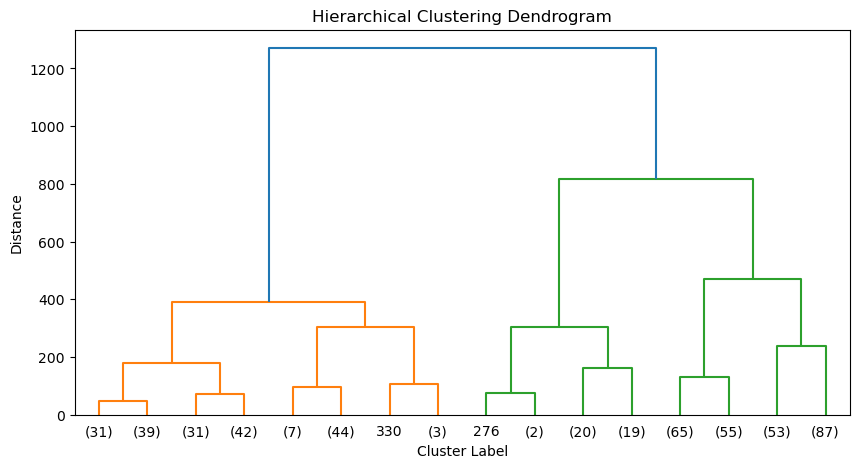

C:\Users\zhang\AppData\Local\Temp\ipykernel_31484\3351446037.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster Label'] = df['Cluster Label'].replace(avg_risk.index, cluster_labels)


In [306]:
df['Cluster Label'] = kmeans.labels_

avg_risk = []
avg_risk = df.groupby('Cluster Label')['Risk Score'].sum()/df['Cluster Label'].value_counts()

# create a condensed distance matrix from the average risk scores
dist_matrix = hierarchy.distance.pdist(avg_risk.values.reshape(-1, 1))

# apply hierarchical clustering with Ward's method
linkage = hierarchy.linkage(dist_matrix, method='ward')

# cluster the average risk scores into 10 clusters
num_clusters = 15
cluster_labels = hierarchy.fcluster(linkage, num_clusters, criterion='maxclust')

# print the cluster labels
print(cluster_labels)

# plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Label')
plt.ylabel('Distance')
hierarchy.dendrogram(linkage, truncate_mode='level', p=3, leaf_font_size=10, labels=avg_risk.index)
plt.show()

# replace the cluster labels with the hierarchical cluster labels
df['Cluster Label'] = df['Cluster Label'].replace(avg_risk.index, cluster_labels)

In [307]:
X_train, X_test, y_train, y_test = train_test_split(df[['Latitude', 'Longitude', 'minutes_since_midnight', 'month', 'day_of_week', "temp", "weather"]], df["Cluster Label"], test_size=0.2, random_state=0)

In [308]:
# Train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=25, random_state=0)
rfc.fit(X_train, y_train)

# Test the model
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9200769536396144


In [313]:
# Define a function to predict collision risk rating
def predict_collision_risk(latitude, longitude, Time_Occurred, month, day_of_week, temp, weather):
    # Preprocess input data
    Time_Occurred = (float(Time_Occurred[:2]) * 60 - min_time)/(max_time-min_time)
    latitude = (latitude-34)*100
    longitude = (longitude+118)*100
    month = (month-1)/11
    temp = (temp-min_temp)/(max_temp-min_temp)
    weather = (weather-min_weather)/(max_weather-min_weather)
    day_of_week = day_of_week/6

    # Create a DataFrame with the input data and feature names
    X = pd.DataFrame([[latitude, longitude, Time_Occurred, month, day_of_week, temp, weather]], columns=['Latitude', 'Longitude', 'minutes_since_midnight', 'month', 'day_of_week', 'temp', 'weather'])

    # Perform PCA
    X_pca = pca.transform(X)

    # Predict the cluster label by random forest classifier
    cluster_label = rfc.predict(X)[0]
    sorted_risk = sorted(avg_risk, reverse=True)
    rank = sorted_risk.index(avg_risk[cluster_label])+1

    # Return the cluster number and average risk score for the cluster

    return cluster_label, avg_risk[cluster_label], rank

In [314]:
print(predict_collision_risk(34.0488, -118.2518, "1800", 9, 2, 12, 0)) #DTLA
print(predict_collision_risk(34.1182, -118.3004, "1800", 9, 2, 12, 0)) #Griffith Observatory

# in order: lattitude, longitude, time, month, day of the week, temperature, weather

# 0 represents Monday, 6 represents Sunday
# 'Clear': 0, 'Haze': 1, 'Mist': 2, 'Rain': 3, 'Clouds': 4, 'Fog': 5, 'Snow': 6
# WE USES CELSIUS!! 

(2, 273.34379947229553, 167)
(4, 195.34360613810742, 444)
